In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import gymnasium as gym
env = gym.make("ALE/KungFuMaster-v5")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [4]:
def transform(state):
    out = torch.from_numpy(state).permute(2, 1, 0)
    out = out.float() / 255.0
    out = F.avg_pool2d(out, kernel_size=2, stride=2)
    out = out[:, :, 52:84] # crop to game field
    return out

def readhealth(state):
    return (state[45, 50:82, 1] > 128).astype(float).mean()

def rollout(env, agent, max_steps=1000, life_penalty=100):
    result = []
    state, info = env.reset()
    state = transform(state)
    health = info['lives']
    for _ in range(max_steps):
        action = agent(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        next_health = 0 if info['lives'] == 0 else (info['lives'] - 1) + readhealth(next_state)
        reward += (next_health - health) * life_penalty # penalize health loss

        result.append((state, action, reward))
        state = transform(next_state)
        health = next_health
        if terminated or truncated:
            break
    return result

def batches(env, agent, batch_size, num_rollouts, max_steps=1000, life_penalty=100, reward_discount=0.99):
    games = []
    gamea = []
    gamer = []
    for _ in range(num_rollouts):
        game = rollout(env, agent, max_steps, life_penalty)
        # score using discounted rewards
        acc_reward = 0
        for i in range(len(game) - 1, -1, -1):
            acc_reward = game[i][2] + reward_discount * acc_reward
            games.append(game[i][0])
            gamea.append(game[i][1])
            gamer.append(acc_reward)

    while len(games) >= batch_size:
        yield games[:batch_size], gamea[:batch_size], gamer[:batch_size]
        games = games[batch_size:]
        gamea = gamea[batch_size:]
        gamer = gamer[batch_size:]

In [5]:
class AtariNet(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(inplace=True)
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(torch.prod(torch.tensor(o.size())))

    def forward(self, x):
        conv_out = self.conv(x)
        # flatten each sample in the batch
        conv_out = conv_out.view(x.shape[0], -1) if len(x.shape) == 4 else conv_out.flatten()
        pred = self.fc(conv_out)
        return pred

class AtariAgent:
    def __init__(self, net):
        self.net = net

    @torch.no_grad()
    def __call__(self, state):
        pred = self.net(state.float())
        assert(len(pred.shape) == 1)
        prob = F.softmax(pred, dim=0)
        act = torch.multinomial(prob, 1)
        return act.item()

Epoch 0 took 19.48s, reward: 46.61, loss: 122.97
Epoch 1 took 17.15s, reward: 42.34, loss: 111.74
Epoch 2 took 19.24s, reward: 43.10, loss: 113.69
Epoch 3 took 18.21s, reward: 48.15, loss: 126.99
Epoch 4 took 19.05s, reward: 46.15, loss: 121.67
Epoch 5 took 17.80s, reward: 42.33, loss: 111.49
Epoch 6 took 18.66s, reward: 40.41, loss: 106.49
Epoch 7 took 19.33s, reward: 33.02, loss: 86.86
Epoch 8 took 18.21s, reward: 37.98, loss: 99.67
Epoch 9 took 20.95s, reward: 84.63, loss: 221.97
Epoch 10 took 19.93s, reward: 69.12, loss: 181.33
Epoch 11 took 19.02s, reward: 54.62, loss: 143.16
Epoch 12 took 21.39s, reward: 65.17, loss: 170.55
Epoch 13 took 22.43s, reward: 67.78, loss: 176.74
Epoch 14 took 20.74s, reward: 63.73, loss: 165.47
Epoch 15 took 22.86s, reward: 72.81, loss: 188.16
Epoch 16 took 22.59s, reward: 93.07, loss: 239.78
Epoch 17 took 22.07s, reward: 82.20, loss: 211.43
Epoch 18 took 21.82s, reward: 93.52, loss: 239.26
Epoch 19 took 21.37s, reward: 85.92, loss: 219.64
Epoch 20 too

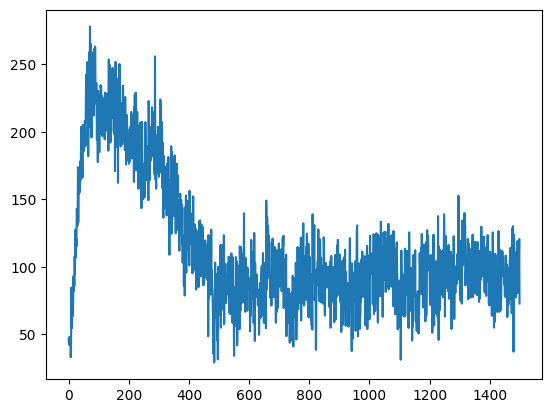

In [6]:
import time

net = AtariNet((3, 32, 80), env.action_space.n)
agent = AtariAgent(net)

optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3)

num_epochs = 1500
num_rollouts = 16
max_steps = 4000
batch_size = 128

epoch_rewards = []

for epoch in range(num_epochs):
    epoch_reward = 0
    epoch_loss = 0
    epoch_start = time.time()
    num_batches = 0

    life_penalty = min(epoch * 4, 2000)

    for bs, ba, br in batches(env, agent, batch_size=batch_size, num_rollouts=num_rollouts, max_steps=max_steps, life_penalty=life_penalty):
        bs = torch.stack(bs)
        ba = torch.tensor(ba, dtype=torch.long)
        br = torch.tensor(br, dtype=torch.float)

        bs = bs.float()

        pred = net(bs)
        log_prob = F.log_softmax(pred, dim=-1)
        loss = (-log_prob[torch.arange(0, ba.shape[0]), ba] * br).mean()

        epoch_reward += br.mean().item()
        epoch_loss += loss.item()
        num_batches += 1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_reward /= num_batches
    epoch_loss /= num_batches

    print(f'Epoch {epoch} took {time.time() - epoch_start:.2f}s, reward: {epoch_reward:.2f}, loss: {epoch_loss:.2f}')

    epoch_rewards.append(epoch_reward)

    torch.save(net.state_dict(), 'kungfu.pth')

plt.plot(epoch_rewards)

In [14]:
net = AtariNet((3, 32, 80), env.action_space.n)
net.load_state_dict(torch.load('kungfu.pth', weights_only=True))

agent = AtariAgent(net)

testenv = gym.make("ALE/KungFuMaster-v5")
observation, info = testenv.reset()
total_steps = 0
total_reward = 0

while True:
    action = agent(transform(observation))
    observation, reward, terminated, truncated, info = testenv.step(action)
    total_reward += reward
    total_steps += 1

    if terminated or truncated:
        break

testenv.close()

print(f'Total reward: {total_reward}, steps {total_steps}')

Total reward: 16000.0, steps 4060
